<h1 style="font-family: Impact, Charcoal, sans-serif; padding: 12px; font-size: 30px; color: #8b4513; text-align: center; line-height: 1.25;">EXPAI Tecnical Test<br><span style="color: #800000; font-size: 48px"><b>Titanic Survival and Fare Predictions</b></span><br><span style="color: #a0522d; font-size: 20px">Binary Classification and Logistic Regression</span></h1>

<div style="display: flex; justify-content: center;">
  <img src="/Users/eo/src/data-ship-api/data/titanic.jpg" alt="Titanic"  style="width:200px;">
</div>

<p>Data source: <a href="https://www.kaggle.com/competitions/titanic/data">Titanic Dataset</a></p>


<h1><b><span style="color: #8b4513; font-size: 28px">TABLE OF CONTENTS</span></b></h1>

* [Exploratory Data Analysis](#1)
    * [Survival Prediction](#1.1)
    * [Fare Prediction](#1.2)
* [Data Preprocessing](#2)
* [Data Visualization](#3)
* [Building Model with Sklearn](#4)
    * [Make Predictions](#4.1)
    * [Prediction Interpretability using SHAP Values](#4.2)
* [Prediction](#5)

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from utils import DataAnalyzer

In [2]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titleweight'] = 'bold'
sns.set_palette('muted')

<a id="1"></a>
<h1><b><span style="color: #8b4513; font-size: 28px">Exploratory Data Analysis Questions</span></b></h1>

In [3]:
# Load the train and test datasets
train_path = '/Users/eo/src/data-ship-api/data/train.csv'
test_path = '/Users/eo/src/data-ship-api/data/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.columns = train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()
train_df = train_df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
test_df = test_df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

train_df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"braund, mr. owen harris",male,22.0,1,0,a/5 21171,7.2500,NaN,s
1,2,1,1,"cumings, mrs. john bradley (florence briggs th...",female,38.0,1,0,pc 17599,71.2833,c85,c
2,3,1,3,"heikkinen, miss. laina",female,26.0,0,0,ston/o2. 3101282,7.9250,NaN,s
3,4,1,1,"futrelle, mrs. jacques heath (lily may peel)",female,35.0,1,0,113803,53.1000,c123,s
4,5,0,3,"allen, mr. william henry",male,35.0,0,0,373450,8.0500,NaN,s


<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #b47238; text-align: left; "><b>Features</b></h1>

- **survived:** 0 = No, 1 = Yes
- **pclass:** A proxy for socio-economic status (SES). 
1st = Upper
2nd = Middle
3rd = Lower
- **age:** Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
- **sibsp:** # of siblings / spouses aboard the Titanic. 
- **parch:** # of parents / children aboard the Titanic. Some children travelled only with a nanny, therefore parch=0 for them.
- **embarked:** Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

#### Update columns names
In order to understand better the columns names and that the names are more selfexplanatory, a rename will be done, also for some values it will be replaced it by the port name. 


In [4]:
train_df = train_df.rename(columns={'embarked': 'embarked_port'})
port_mapping = {'s': 'southampton', 'q': 'queenstown', 'c': 'cherbourg'}
train_df['embarked_port'] = train_df['embarked_port'].map(port_mapping)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   passengerid    891 non-null    int64  
 1   survived       891 non-null    int64  
 2   pclass         891 non-null    int64  
 3   name           891 non-null    object 
 4   sex            891 non-null    object 
 5   age            714 non-null    float64
 6   sibsp          891 non-null    int64  
 7   parch          891 non-null    int64  
 8   ticket         891 non-null    object 
 9   fare           891 non-null    float64
 10  cabin          204 non-null    object 
 11  embarked_port  889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Drop column passenger id 

In [6]:
column_to_exclude = 'passengerid'
train_df.drop('passengerid', inplace=True, axis=1)

In [7]:
train_df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
print(f'Train dataset shape: {train_df.shape}')

Train dataset shape: (891, 11)


<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #b47238; text-align: left; "><b>Check missing values and unique values</b></h1>

In [9]:
display(DataAnalyzer.get_missing_values(train_df))
""" null_per_column = train_df.isnull().sum()
nulls_grt_zero = null_per_column[null_per_column > 0].sort_values(ascending=False)
total_datos = train_df.shape[0]
perc_nulls = nulls_grt_zero / total_datos * 100
nulls_table = pd.concat([nulls_grt_zero, perc_nulls], axis=1)
nulls_table.columns = ['Total Nulos', '% Nulos']
tabla_nulos = nulls_table.style.background_gradient(cmap='Oranges',
                                                    low=0,
                                                    high=1)
display(tabla_nulos) """

,Total Nulos,% Nulos
cabin,687,77.104377
age,177,19.865320
embarked_port,2,0.224467


" null_per_column = train_df.isnull().sum()\nnulls_grt_zero = null_per_column[null_per_column > 0].sort_values(ascending=False)\ntotal_datos = train_df.shape[0]\nperc_nulls = nulls_grt_zero / total_datos * 100\nnulls_table = pd.concat([nulls_grt_zero, perc_nulls], axis=1)\nnulls_table.columns = ['Total Nulos', '% Nulos']\ntabla_nulos = nulls_table.style.background_gradient(cmap='Oranges',\n                                                    low=0,\n                                                    high=1)\ndisplay(tabla_nulos) "

In [10]:
print(f'Number of unique values in each column of the train dataset: {train_df.nunique()}')

Number of unique values in each column of the train dataset: survived           2
pclass             3
name             891
sex                2
age               88
sibsp              7
parch              7
ticket           681
fare             248
cabin            147
embarked_port      3
dtype: int64


<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #b47238; text-align: left; "><b>Target Variable 'survived' Distribution</b></h1>

In [11]:
print(f'Target variable distribution:\n{train_df.survived.value_counts()}')
total_instances = train_df['survived'].count()
class_0_count = train_df['survived'].value_counts()[0]
class_1_count = train_df['survived'].value_counts()[1]

proportion_class_0 = class_0_count / total_instances
proportion_class_1 = class_1_count / total_instances

print(f'Proportion of class 0 (non-survivors): {proportion_class_0:.2f}')
print(f'Proportion of class 1 (survivors): {proportion_class_1:.2f}')

Target variable distribution:
0    549
1    342
Name: survived, dtype: int64
Proportion of class 0 (non-survivors): 0.62
Proportion of class 1 (survivors): 0.38


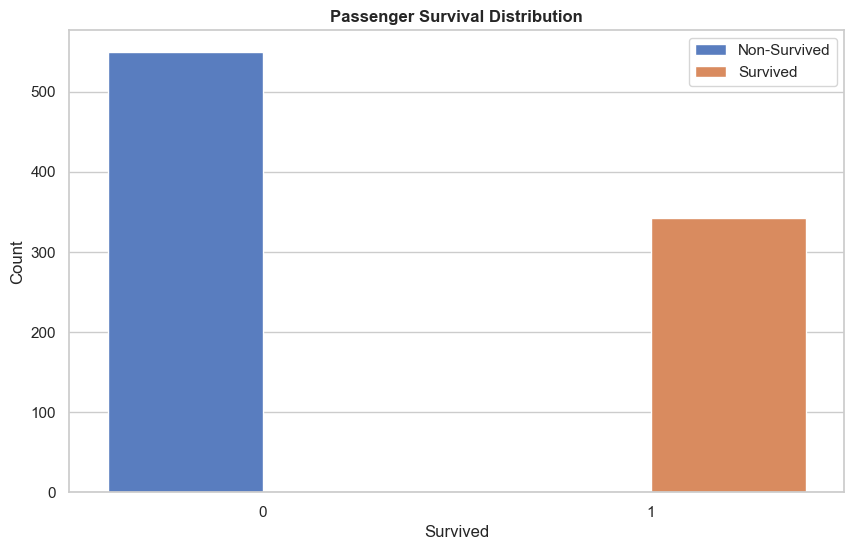

In [12]:
sns.countplot(x='survived', data=train_df, hue="survived")  
plt.xlabel('Survived')  
plt.ylabel('Count')  
plt.title('Passenger Survival Distribution')  
plt.legend(labels=['Non-Survived', 'Survived'])
plt.show()


In [13]:
print("Categorical feature distributions:")
print(train_df['sex'].value_counts())
print(train_df['pclass'].value_counts())
print(train_df['embarked_port'].value_counts())

Categorical feature distributions:
male      577
female    314
Name: sex, dtype: int64
3    491
1    216
2    184
Name: pclass, dtype: int64
southampton    644
cherbourg      168
queenstown      77
Name: embarked_port, dtype: int64


In [14]:
print("Outliers in 'Age':")
train_df[train_df['age'] > train_df['age'].mean() + 3 * train_df['age'].std()]

Outliers in 'Age':


,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked_port
630,1,1,"barkworth, mr. algernon henry wilson",male,80.0,0,0,27042,30.000,a23,southampton
851,0,3,"svensson, mr. johan",male,74.0,0,0,347060,7.775,NaN,southampton


In [15]:
print("Outliers in 'Fare':")
fare_outliers = train_df[train_df['fare'] > train_df['fare'].mean() + 3 * train_df['fare'].std()]
fare_outliers[fare_outliers.fare>300]

Outliers in 'Fare':


,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked_port
258,1,1,"ward, miss. anna",female,35.0,0,0,pc 17755,512.3292,NaN,cherbourg
679,1,1,"cardeza, mr. thomas drake martinez",male,36.0,0,1,pc 17755,512.3292,b51 b53 b55,cherbourg
737,1,1,"lesurer, mr. gustave j",male,35.0,0,0,pc 17755,512.3292,b101,cherbourg


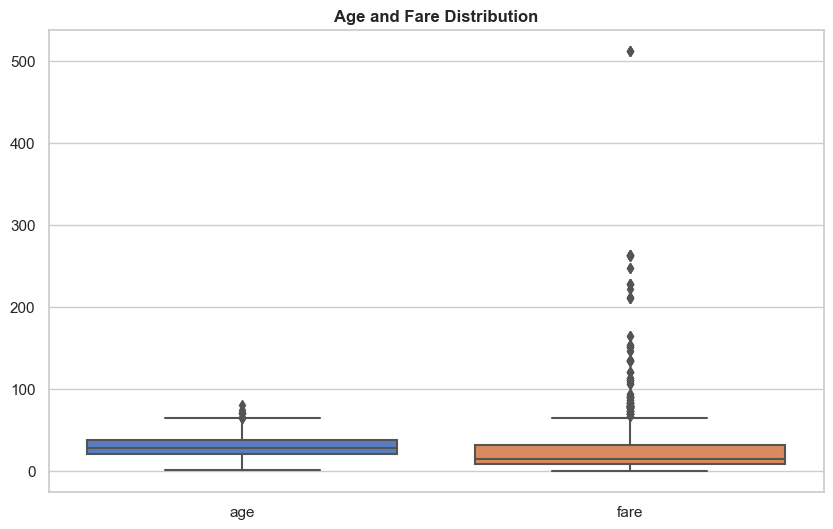

In [16]:
def plot_side_by_side_violin(data, title):
    sns.boxplot(data=data[["age", "fare"]], orient="v")
    plt.title(f'{title}')
    plt.show()

plot_side_by_side_violin(train_df, 'Age and Fare Distribution')


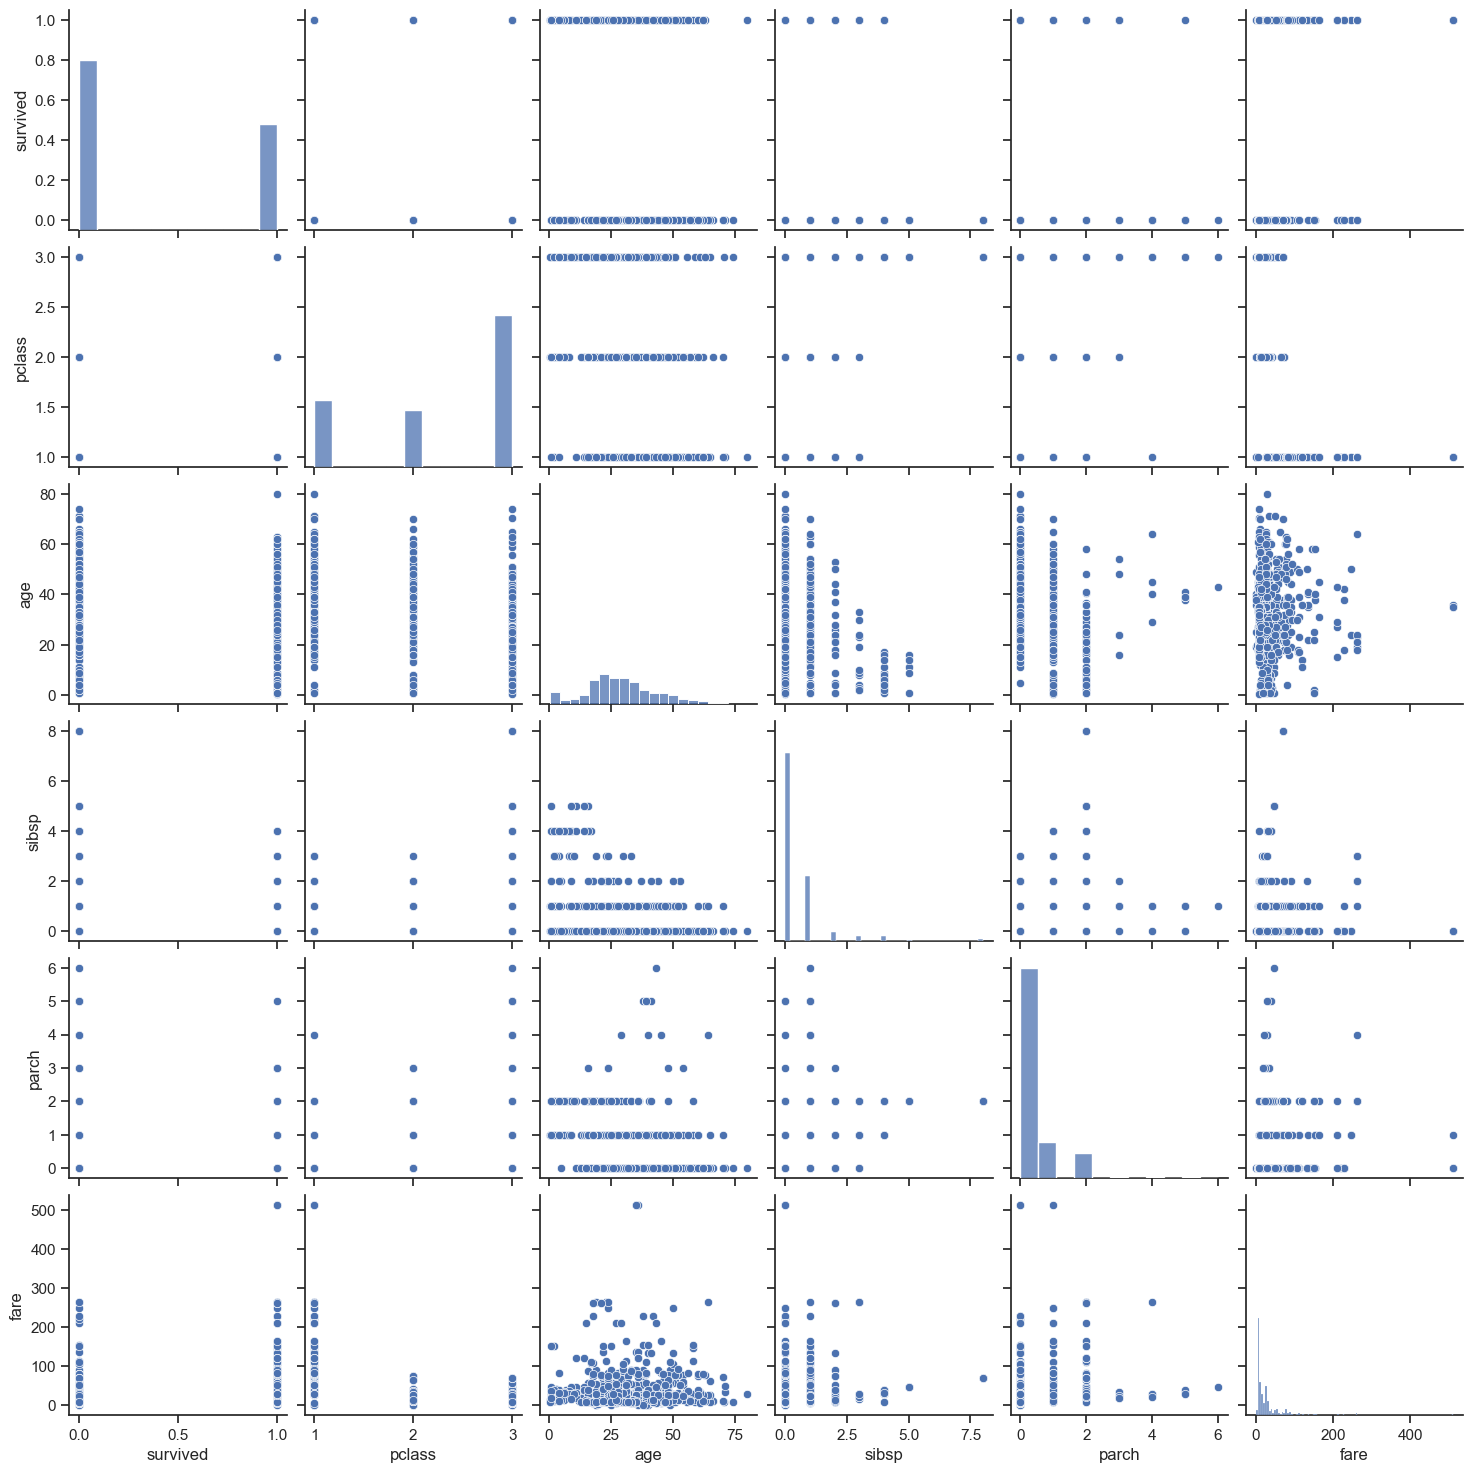

In [17]:
sns.set(style="ticks") 
sns.pairplot(train_df)
plt.show()

<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #b47238; text-align: left; "><b>Initial Conclusions from Exploratory Data Analysis (EDA):</b></h1>

1. The train dataset contains 891 records and 12 columns, meaning it contains information about 891 passengers and various aspects related to them.

2. The 'cabin' column has a significant number of missing values, approximately 77% of the data is missing. This could be a challenge for our analysis and modeling since we have limited information about the cabins.

3. The 'age' column also has missing values, but the percentage is relatively lower, around 19.8%. We will need to handle these missing values thoughtfully to avoid bias in our analysis.

4. The 'embarked' column has only 2 missing values, which is a small proportion of the dataset. We can consider various strategies to deal with these missing values, such as imputation or excluding those rows.

5. The target variable is called 'survived', and it indicates whether a passenger survived (1) or not (0). The data is imbalanced with 62% of non-survivors and 38% of survivors. This imbalance might impact our model's performance, and we might need to use techniques like resampling or different evaluation metrics to handle it.

6. The mean survival rate is approximately 38.38%, indicating that about 38.38% of the passengers in the dataset survived the Titanic disaster.

7. The passengers' ages range from approximately 5 months (0.42 years) to 80 years old, with an average age of around 29.70 years.

8. On average, passengers tend to travel with few family members. The 'sibsp' column, representing the number of siblings and spouses aboard, has a mean value of 0.52, and the 'parch' column, representing the number of parents and children aboard, has a mean value of 0.38.

9. The average fare paid by passengers is approximately 32.20 units. However, some passengers received complimentary tickets or traveled for free, as indicated by the minimum fare of 0 units. On the other hand, some passengers paid significantly higher fares, with the maximum fare being 512.33 units.

***Additional Insights:***

10. Three passengers paid the highest fare of 512.33 units and survived the disaster. They were embarked at the port Cherbourg and belonged to the first class. Their ages were between 35 and 36 years old, and interestingly, most of them were traveling alone, except one passenger who had either a parent or child aboard.

<a id="1.1"></a>
<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #b47238; text-align: left; "><b>Survival Prediction</b></h1>

1. **Survival by Class**
   - How does the passenger class (1st, 2nd, or 3rd) influence the survival rate?

In [18]:
gr_data = Utils.calculate_survival_percentage(train_df, 'pclass')
Utils.plot_survival_by_feature(gr_data, 'pclass', 'Passenger Class','Percentage of Passengers', 'Percentage of Survival and Non-Survival by Passenger Class' )

NameError: name 'Utils' is not defined

**Based on the analysis of survival rate by passenger class, the following conclusions can be drawn:**

1. Passengers in the third class had the lowest survival rate among all three classes, with only 24.2% surviving the disaster. Despite constituting the majority of the passengers onboard, the survival rate is the lowest. 

2. On the other hand, first-class passengers had a much higher survival rate of 63%. Despite being a minority in terms of population onboard, they had a significantly higher chance of surviving the tragedy.

3. The second-class passengers had a survival rate of approximately 47%, which is only slightly higher than their not-survived rate of 52%. Their survival chances were more balanced compared to the other classes.

The analysis indicates that belonging to the first class increased the likelihood of survival. This might be attributed to the allocation of resources and priority during the evacuation process, with first-class passengers potentially having easier access to lifeboats and safety measures.

Overall, the data suggests a clear correlation between passenger class and survival rate. Passengers in the higher-class cabins, specifically the first class, had a significantly better chance of surviving the Titanic disaster compared to those in the lower-class cabins. This could be due to various factors, including location of the cabins, access to lifeboats, and preferential treatment during evacuation that will be analyzed further. 

2. **Survival by Gender**
   - What is the survival rate for males and females?

In [ ]:
grouped_sex = train_df.groupby(['sex', 'survived']).size().reset_index(name='count')
total_passengers_by_sex = grouped_sex.groupby('sex')['count'].sum().reset_index()
grouped_sex = grouped_sex.merge(total_passengers_by_sex, on='sex', suffixes=('', '_total'))
grouped_sex['survival_percentage'] = grouped_sex['count'] / grouped_sex['count_total'] * 100
grouped_sex

In [ ]:
ax = sns.barplot(x='sex', y='survival_percentage', hue='survived', data=grouped_sex)
plt.xlabel('Passenger Class')
plt.ylabel('Percentage of Passengers')
plt.title('Percentage of Survival and Non-Survival by Sex', fontsize=16)

ax.legend(title='Survived', loc='upper left', facecolor='white', framealpha=1)

# Annotate the bars with the percentage values
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()


5. **Family Size**
   - What is the distribution of family sizes (SibSp + Parch) among passengers?

6. **Port of Embarkation**
   - How many passengers embarked from each port, and how does it relate to survival?

7. **Survival by Cabin Deck**
   - Does the deck level of the cabin influence survival rates?

8. **Title Analysis**
   - Can we extract titles from passenger names and see if they correlate with survival?

9. **Correlation Analysis**
   - Explore correlations between different features and survival.

<a id="1.2"></a>
<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #b47238; text-align: left; "><b>Fare Prediction</b></h1>

<details>

1. **Fare Distribution**
   - What is the distribution of fares paid by passengers?

2. **Fare by Class**
   - How does the fare distribution vary across different passenger classes (1st, 2nd, 3rd)?

3. **Fare vs. Cabin Deck**
   - Investigate if there is any correlation between the fare paid and the cabin deck assigned.

4. **Fare by Port of Embarkation**
   - Analyze whether the fares paid differ based on the port of embarkation.

5. **Fare by Family Size**
   - Explore how the fare amount is related to the size of the passenger's family.

7. **Correlation between Fare and Other Features**
   - Investigate correlations between fare and other features, such as age, gender, or survival.

9. **Survival vs. Fare**
   - Analyze the relationship between survival and fare paid by passengers.

</details>

In [ ]:
age_by_class = train_df.groupby('pclass').age.count()
age_by_class

In [ ]:
df = sns.load_dataset("titanic")
sns.boxplot(data=df, x="age", y="class", hue="alive")

In [ ]:
df